**Fellowship.AI - ULMFiT Sentiment Analysis Challenge**

**by Endre Sukosd - June, 2019**

# Data preparation

Set variable *path_to_data* to url pointing to the Twitter US Airline Sentiment dataset.

In [0]:
path_to_data = 'https://github.com/semmi88/data/raw/master/Tweets.csv'

Read data into Pandas dataframe, view shape and explore columns.

In [0]:
import pandas as pd
df = pd.read_csv(path_to_data)

In [0]:
print("Data shape {}".format(df.shape))
samples = df.shape[0]
df.head()

Data shape (14640, 15)


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


The column *airline_sentiment_gold* looks interesting, let's explore the values.

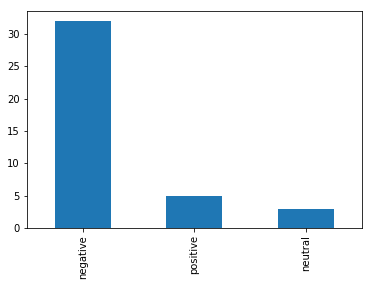

In [0]:
df.airline_sentiment_gold.value_counts().plot(kind='bar')

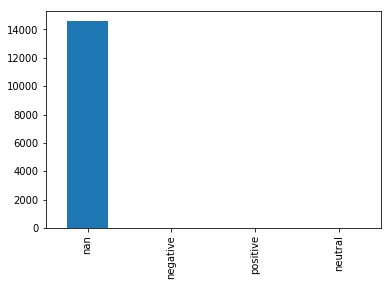

In [0]:
df.airline_sentiment_gold.value_counts(dropna = False).plot(kind='bar')

In [0]:
df[df.airline_sentiment_gold.notna() == True].airline_sentiment_gold.count()

40

Almost all values for *airline_sentiment_gold* are missing, NAN, so this column does not seem to be useful. 

Let's look at some tweets.

In [0]:
pd.options.display.max_colwidth = 400
df['text'].sample(10)

3863                            @united surprise me.  Otherwise, the flight is over and I don't have a good feeling about your airline.
4795     @southwestair,  kudos to your rep "Patricia" at gate B11 this Sunday morning at #Chicago #Midway #MDW,… http://t.co/MmCWkqp2gy
637                @united ours in July. You have ZERO excuses for this. You have an out-of-date system that causes problems like this.
5647                                                                                                  @SouthwestAir will do. Thank you.
6953                                                                                                                      STOP @JetBlue
9007          @USAirways after being assured by the pleasant woman at gate B11 in Albany, NY that life's not perfect, I'd heard enough.
11332                         @USAirways if you could have ran your USExpress/PSA worth a damn I wouldn't be stuck in horrible CLT now.
13409                                           

It seems that tweets always start with a reference to the airlines' Twitter handle (e.g.: @AmericanAir). Let's explore how the reviews are distribuited amongst the airlines.

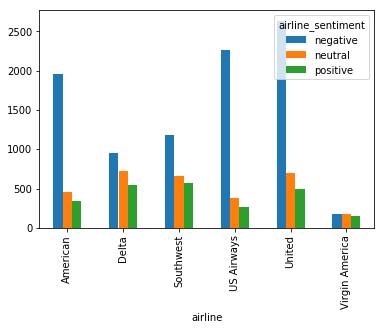

In [0]:
df.groupby(['airline', 'airline_sentiment']).size().unstack().plot(kind='bar')

We can see that the dataset again is skewed, for some airline we have way less reviews than for others. But more importantly, for some airlines (Virgin America) we have reviews of all sentiments in equal proportions, and for others (United) the negative reviews dominate. This means that our model could learn that having a reference to United in the tweet's text is a strong signal that a review is most probably negative. We should get rid of this kind of bias.

We will create a new column in the dataframe, which will contain cleaned tweets, removing all references to the airlines.

In [0]:
df['text_lower']=df['text'].str.lower()
twitter_handles = df['text_lower'].str.extractall('(?P<handles>[@]\w*)')

handle_freq = twitter_handles['handles'].value_counts()

handle_freq[handle_freq > 5]

@united             3894
@usairways          3000
@americanair        2961
@southwestair       2458
@jetblue            2248
@virginamerica       519
@                     76
@delta                68
@imaginedragons       45
@phlairport           20
@dfwairport           17
@wsj                  13
@ladygaga             12
@fortunemagazine      12
@carrieunderwood      12
@love_dragonss        10
@flytpa                9
@virginatlantic        9
@cowboycerrone         9
@spiritairlines        8
@gg8929                8
@velourlive            8
@staralliance          8
@aircanada             7
@bostonlogan           6
@fly2ohare             6
@triflight             6
@dulles_airport        6
@cnn                   6
Name: handles, dtype: int64

Based on the above handle frequencies, we will strip out the top handles from all the texts. These are:
* @united|@usairways|@americanair|@southwestair|@jetblue|@virginamerica|@delta



In [0]:
df['text_cleaned'] = df['text_lower'].str.replace('@united|@usairways|@americanair|@southwestair|@jetblue|@virginamerica|@delta','')

Let's verify that the cleaning was succesful

In [0]:
cleaned_twitter_handle_freq = df['text_cleaned'].str.extractall('(?P<handles>[@]\w*)')['handles'].value_counts()

cleaned_twitter_handle_freq[cleaned_twitter_handle_freq > 5]

@                   76
@imaginedragons     45
@phlairport         20
@dfwairport         17
@wsj                13
@fortunemagazine    12
@ladygaga           12
@carrieunderwood    12
@love_dragonss      10
@virginatlantic      9
@cowboycerrone       9
@flytpa              9
@spiritairlines      8
@velourlive          8
@gg8929              8
@staralliance        8
@aircanada           7
@dulles_airport      6
@triflight           6
@bostonlogan         6
@fly2ohare           6
@cnn                 6
Name: handles, dtype: int64

In [0]:
df['text_cleaned'].sample(5)

6718                                                           i need updates on my flights 464 &amp; 3574. i have been on hold for over 2 hours.
1089             flight 211/ord gate agent tried to prevent me from taking onboard a bag i've used for 15 years! flight crew was more reasonable!
8730           the gate agent said our original plane got de-icing fluid in the engine that created a short so they took the plane out of service
11525                              so you're going to make me wait that long on the phone line when you can help me? # that's part of the problem
4006      this link in your tweet goes to someone's internal email -&gt; http://t.co/zksx79itdn...... probably one of your 3rd party it contracts
Name: text_cleaned, dtype: object

Next let's check the distribution of *airline_sentiment* and *airline_sentiment_confidence* column values.

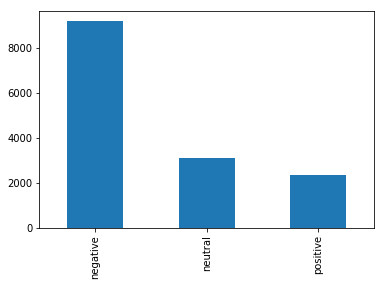

In [0]:
df.airline_sentiment.value_counts(dropna = False).plot(kind='bar')

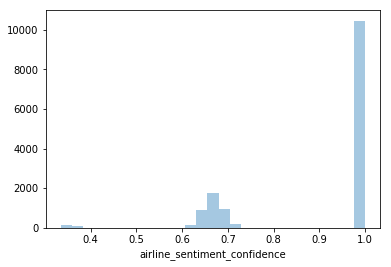

In [0]:
import seaborn as sns

sns.distplot(df.airline_sentiment_confidence, kde=False)

In [0]:
df[df.airline_sentiment_confidence > 0.6].airline_sentiment_confidence.count()

14402

We see that our classes are heavily skewed, dominated by negative reviews. 

Also, based on the above analysis we can create a high confidence subset of the data, where the *airline_sentiment_confidence* is greater than 0.6, and a highest confidence subset, where it is 1.00.

In [0]:
df_subset=df[['airline_sentiment','text_cleaned','text','airline_sentiment_confidence']]
df_subset=df_subset.rename(columns={'airline_sentiment' : 'label'})

df_all = df_subset[['text','text_cleaned','label']]
df_high_conf = df_subset[df_subset.airline_sentiment_confidence > 0.6][['text','text_cleaned','label']]
df_highest_conf = df_subset[df_subset.airline_sentiment_confidence == 1.0][['text','text_cleaned','label']]

print('All samples: {}'.format(df_all.shape[0]))
print('>0.6 confidence samples: {}'.format(df_high_conf.shape[0]))
print('1.0 confidence samples: {}'.format(df_highest_conf.shape[0]))

df_high_conf.head()

All samples: 14640
>0.6 confidence samples: 14402
1.0 confidence samples: 10445


,text,text_cleaned,label
0,@VirginAmerica What @dhepburn said.,what @dhepburn said.,neutral
2,@VirginAmerica I didn't today... Must mean I need to take another trip!,i didn't today... must mean i need to take another trip!,neutral
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse","it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",negative
4,@VirginAmerica and it's a really big bad thing about it,and it's a really big bad thing about it,negative
5,@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA,seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying va,negative


# Baseline - other works

I've found other works on Kaggle, using the very same dataset and doing sentiment analysis/classification:
* https://www.kaggle.com/anjanatiha/sentiment-analysis-with-lstm-cnn 
*  https://www.kaggle.com/wesleyliao3/sentiment-analysis-using-rnn-lstm-ulmfit
* https://www.kaggle.com/carlolepelaars/predicting-sentiment-with-ml-80-accuracy

In these various approaches/models were tried out (CNN, ULMFit, XGBoost) and the best results gave and accuracy of about **79%** on the test set. 

This can be used as a first baseline, approximation of the potentially achivable results on this task & dataset.



# Baseline - first approach

First, let's try a basic approach for predicting the sentiment of the tweets. 

For this we will be using an AWS-LSTM model, from fast.ai library (text module), without pretraining. We will also rely on default values for hyperparameter, just to get a first initial results.



Install fast.ai packages for Colab.

In [0]:
  !curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
from fastai.text import *

Let's create the DataBunch from our dataframe, for text classification, using the Data Block API.
* We will only use all the data (df_all) with the original text (cols=text)
* We will use a random split between training and validation data (80%/20%)
* Lables will be taken from the corresponding column


In [0]:
data_cls_not_pretrained = (TextList.from_df(df=df_all, cols='text')
               .split_by_rand_pct(0.20)
               .label_from_df(cols='label')
               .databunch())

The above command did create the DataBunch, and also tokenized, numericalized the text input.

In [0]:
data_cls_not_pretrained.train_ds[0][0]

Text xxbos @virginamerica plus you 've added commercials to the experience ... xxunk .

In [0]:
data_cls_not_pretrained.train_ds[0][0].data

array([   2,  102,  575,   17,  115, 1090, 2210,   10,   12,  239,   66,    0,    9])

Let's create a Learner for Text Classification, using an AWD_LSTM model architecture and the DataBunch created above. We will not use the pre-trained version of the model for this initial trial, the model should have randomly initializd weights.

In [0]:
learn_cls_not_pretrained = text_classifier_learner(data_cls_not_pretrained, text.models.AWD_LSTM, pretrained=False, metrics=[accuracy, error_rate])
learn_cls_not_pretrained.summary()

SequentialRNN
Layer (type)         Output Shape         Param #    Trainable 
RNNDropout           [59, 400]            0          False     
______________________________________________________________________
RNNDropout           [59, 1152]           0          False     
______________________________________________________________________
RNNDropout           [59, 1152]           0          False     
______________________________________________________________________
BatchNorm1d          [1200]               2,400      True      
______________________________________________________________________
Dropout              [1200]               0          False     
______________________________________________________________________
Linear               [50]                 60,050     True      
______________________________________________________________________
ReLU                 [50]                 0          False     
________________________________________________

Let's start training the model for a few epochs with default learning rates (slice(3e-3), [source code](https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L191)).

In [0]:
learn_cls_not_pretrained.fit(3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.715819,0.610862,0.771175,0.228825,00:15
1,0.601760,0.540859,0.781079,0.218921,00:16
2,0.533464,0.539647,0.788593,0.211407,00:16


In [0]:
def train_acc(learner):
  train_preds=learner.get_preds(ds_type=DatasetType.Train)
  train_acc = accuracy(train_preds[0],train_preds[1])
  print('Training set accuracy {}'.format(train_acc.item()))
  return train_preds, train_acc

In [0]:
train_preds, acc = train_acc(learn_cls_not_pretrained)

This is a promising start. Around 82% accuracy on the training set, and around  **79%** accuracy on the validation set.

This result is similar to those results seen in other works. This is probably due to the fast.ai library quickly evolving and having very well chosen defaults.

Let's check the F1 score as well, to see how does this first model do on Precision and Recall combined.

In [0]:
def transform_to_one_hot_enc(preds):
  classes = max(preds) + 1
  one_hot_np = np.eye(classes)[preds]
  one_hot_pyt = torch.from_numpy(one_hot_np)
  return one_hot_pyt

In [0]:
print(train_preds[1])
one_hots = transform_to_one_hot_enc(train_preds[1])
print(one_hots)

In [0]:
f1score = fbeta(train_preds[0], one_hots, thresh=0.5, beta=1, sigmoid=False)
print('F1 score {}'.format(f1score.item()))

F1 score 0.8011441230773926


In [0]:
#free up memory
learn_cls_not_pretrained.purge()
learn_cls_not_pretrained.destroy()

this Learner object self-destroyed - it still exists, but no longer usable


# ULMFiT - Using a pre-trained Language Model

Let's create the DataBunch from our dataframe, which we can use to fine-tune the Language Model.

A Language Model predicts the next words in a text, and so the label (*airline_sentiment*) or the label confidence (*airline_sentiment_confidence*) does not really matter in this case. We can even use the texts with low sentiment confidence values, to fine-tune with as much text data, as possible. We will apply a random split of all of the data, using only 10% for validation. 


We again use the Data Block API:
* use all the cleaned text data, even text with low sentiment confidence
* split randomly, 10% for validation is enough, as here we do not really care about the performance of the model (our final goal will be classification, not next work prediction)
* we label the DataBunch for Language Model.

The following command will also tokenize, numericalize the text input.

In [0]:
data_lm = (TextList.from_df(df=df_all, cols='text_cleaned')
           .split_by_rand_pct(0.10)
           .label_for_lm()
           .databunch())

In [0]:
data_lm.show_batch()


idx,text
0,"\n it 's really the only bad thing about flying va xxbos yes , nearly every time i fly vx this “ xxunk xxunk ” wo n’t go away :) xxbos really missed a prime opportunity for men without hats xxunk , there . https : / / t.co / xxunk xxbos well , i xxunk … but now i do ! : xxunk xxbos it was amazing ,"
1,"browsers and the problem continues xxbos thanks guys ! sweet route over the xxunk # xxunk xxbos love the xxunk music blasting at gate in # boston while waiting for flight to # sanfrancisco . only if i could get an iced coffee ! xxbos - the passenger in xxunk , flt xxunk that assaulted me should n't have flown . i trust he 's xxunk . crew filed report"
2,! ! happy customer . xxbos still no refund or word via dm . please resolve this issue as your cancelled flightled flight was useless to my xxunk 's trip . xxbos delayed due to lack of crew and now delayed again because there 's a long line for deicing ... still need to improve service # united xxbos thanks -- we filled it out . how 's our luck
3,"united i understand that . but he would actually like his own bag back ! what have you done with it ? ! he also wants the money .. xxbos xxunk worse customer service ever . problems will happen , how you deal xxunk a company . never again united . xxbos it 's still a valid flight . just seems strange to delay for late flight inbound crew ,"
4,". i 've been doing this for 15 yrs xxbos i 've never experienced worst customer service . xxunk blame on codeshare partners and not assuming responsibility is unacceptable xxbos currently on board so not now . check in was terrible . staff rude . expensive luggage xxunk around etc . xxbos fucked up , then xxunk my ticket , and kept my money . not even an apology ."


Let's take a quick look at the vocabulary, training and validatin datasets sizes

In [0]:
print(len(data_lm.vocab.itos))
print(data_lm.vocab.itos)
print(len(data_lm.train_ds))
print(len(data_lm.valid_ds))

4400
['xxunk', 'xxpad', 'xxbos', 'xxeos', 'xxfld', 'xxmaj', 'xxup', 'xxrep', 'xxwrep', '.', 'to', 'i', 'the', '!', 'a', '?', '/', 'you', ',', 'for', 'flight', 'on', 'and', '#', 'my', 'is', 'in', 'it', 'of', "n't", 'me', ':', 'that', 'have', 'your', 'was', 'not', 'with', '-', 'no', "'s", 'at', 'do', 'this', 'get', '&', 'we', 'but', 't.co', 'from', 'be', 'can', 'http', 'are', 'thanks', 'cancelled', 'now', 'an', 'just', 'service', 'so', '"', 'help', '...', 'been', 'what', '2', 'time', 'will', 'they', 'customer', 'up', 'out', 'all', "'m", 'us', 'our', 'how', 'hours', 'when', 'there', 'hold', 'plane', 'flights', 'would', 'if', 'why', 'thank', 'still', 'ca', '4', 'one', 'need', 'please', 'did', 'delayed', 'call', 'back', 'had', 'about', 'gate', 'has', 'am', 'bag', 'or', 'flightled', 'as', 'got', 'hour', 'after', "'ve", 'late', ')', 'phone', 'like', 'any', 'today', 'over', '$', 'airline', 'more', 'again', '(', 'by', 'fly', 'guys', '3', 'should', 'waiting', 'does', 'know', 'way', 'airport', 't

Download a Language Model pre-trained on a cleaned subset of wikipedia, using and AWD_LSTM architecture, from the fast.ai library.

We use the DataBunch and this model to create a Learner. The dropout multiplier is set to the default 1.0, which is higher than the 0.3 used in the [fast.ai example notebook](https://nbviewer.jupyter.org/github/fastai/course-v3/blob/master/nbs/dl1/lesson3-imdb.ipynb), because I observed that the model tends to overfit more.

In [0]:
learn_lstm = language_model_learner(data_lm, AWD_LSTM, drop_mult=1.0, pretrained=True, metrics=[accuracy])


Let's find a good value for the learning rate hyperparameter.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


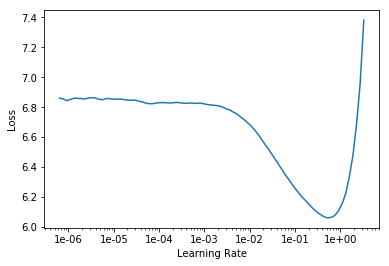

In [0]:
learn_lstm.lr_find()
learn_lstm.recorder.plot(skip=15)

# ULMFiT - Fine-tuning the Language Model

Let's fine-tune the pre-trained Language Models, using our dataset. With this step our goal is to get to a good enough accuracy, which for a Language Model would be around 30%.

Let's start training the AWD_LSTM model.
 * using a max learning rate of 0.01, as suggested by the output of lr_find() 
 * train following the 1-cycle policy
 * specify max and min momentum as suggested by [fast.ai lesson](https://nbviewer.jupyter.org/github/fastai/course-v3/blob/master/nbs/dl1/lesson3-imdb.ipynb)



In [0]:
learn_lstm.fit_one_cycle(5,1e-2,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.886246,4.616339,0.209235,00:09
1,4.920907,4.184552,0.250949,00:08
2,4.509851,4.085212,0.259319,00:08
3,4.300238,4.048494,0.263979,00:08
4,4.192236,4.042746,0.265039,00:09


As recommended by fast.ai, after training the last layers we should unfreeze and train the whole model (all layer groups trainable). Let's use a smaller max learning rate this time.

In [0]:
learn_lstm.unfreeze()
learn_lstm.fit_one_cycle(10,1e-3,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.089420,3.986661,0.269475,00:12
1,4.021223,3.931994,0.275670,00:12
2,3.930315,3.873796,0.281724,00:12
3,3.823872,3.838319,0.286356,00:13
4,3.720462,3.819130,0.288867,00:13
5,3.614754,3.810714,0.290458,00:13
6,3.519435,3.812686,0.290569,00:13
7,3.439393,3.813638,0.291239,00:13
8,3.379971,3.816332,0.290569,00:13
9,3.351178,3.816719,0.290653,00:13


We managed to fine-tune the pre-trained AWD_LSTM Language Model to have an accuracy of **~29%** on Twitter next word prediction.

Let's save the Encoder part of the fine-tuned Language Model, so we can use it later for classification.

In [0]:
learn_lstm.save_encoder('fine_tuned_enc_lstm')

# ULMFiT - Classification / Sentiment analysis

As we saw earlier our classes are skewed (dominated by negative review). We should try to use startified sampling for creating a better distribuited training and validation set (both containing the same ratio of negative, positive and neutral examples).

In [0]:
# We need to reset the indexes, because we are working on the high-confidence subset only, but using the indexes from the whole dataset
df_high_conf = df_high_conf.reset_index(drop=True)

seed = 100

neg_i = (df_high_conf[df_high_conf.label == 'negative']).index
pos_i = (df_high_conf[df_high_conf.label == 'positive']).index
neu_i = (df_high_conf[df_high_conf.label == 'neutral']).index


def split_indexes(indexes,ratio,seed):
  np.random.seed(seed)
  indexes_perm = np.random.permutation(indexes)
  split = int(ratio * len(indexes))
  return indexes_perm[:split], indexes_perm[split:]

train_neg_i, valid_neg_i = split_indexes(neg_i,0.8,seed)
train_pos_i, valid_pos_i = split_indexes(pos_i,0.8,seed)
train_neu_i, valid_neu_i = split_indexes(neu_i,0.8,seed)


train_idx = np.random.permutation(np.concatenate([train_neg_i,train_pos_i,train_neu_i]))
valid_idx = np.random.permutation(np.concatenate([valid_neg_i,valid_pos_i,valid_neu_i]))


print('Training set {}'.format(len(train_idx)))
print('Validation set {}'.format(len(valid_idx)))

Training set 11520
Validation set 2882


In [0]:
train_df = df_high_conf.iloc[train_idx]
train_df.reset_index(drop=True, inplace=True)

valid_df = df_high_conf.iloc[valid_idx]
valid_df.reset_index(drop=True, inplace=True)

Let's create another DataBunch, which we will use for Classification, which in this case will be sentiment analysis. 

For this we will only use the train, validatim and test dataframe created from the high confidence dataset. We will use the cleaned texts, and will reuse the same vocabulary - as for the fine-tuned language mode. Labels will come from the corresponding column.


In [0]:
data_cls = (TextList.from_df(df=df_high_conf, cols='text_cleaned', vocab=data_lm.vocab)
           .split_by_idx(valid_idx)
           .label_from_df(cols='label')
           .databunch())

We have to make sure to use the same vocabulary for the Classification, as we used for the Language Model, to take advantage of the pre-trained/fine-tuned model.

In [0]:
print(len(data_lm.vocab.itos))
print(data_lm.vocab.itos[:10])
print(len(data_cls.vocab.itos))
print(data_cls.vocab.itos[:10])

4392
['xxunk', 'xxpad', 'xxbos', 'xxeos', 'xxfld', 'xxmaj', 'xxup', 'xxrep', 'xxwrep', '.']
4392
['xxunk', 'xxpad', 'xxbos', 'xxeos', 'xxfld', 'xxmaj', 'xxup', 'xxrep', 'xxwrep', '.']


Let's verify that training and validation set have the same distribution of negative, neutral and positive reviews.

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


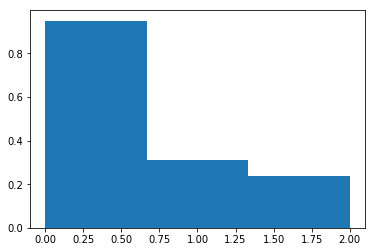

In [0]:
import matplotlib.pyplot as plt
values = data_cls.train_ds.y.items
plt.hist(values, normed=True, bins=3)
plt.show()

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


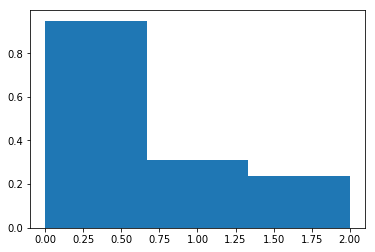

In [0]:
import matplotlib.pyplot as plt
values = data_cls.valid_ds.y.items
plt.hist(values, normed=True, bins=3)
plt.show()

In [0]:
data_cls.show_batch()

text,target
"xxbos i ❤ ️ jetblue but i was on flt xxunk from fll to sfo . xxunk off was over 1 hr late flight , div to phx & & got in 2 hrs late flight . what will be done ?",negative
"xxbos "" will my luggage be on that flight ? "" "" no "" "" y not "" "" bc ur on that flight n it wo n't end up where ur goin http : / / t.co / xxunk",negative
xxbos poor experience 2day at ord xxunk . 8 xxunk . w / 3 cust . 10 waiting . asked to speak w / supervisor . told 20 min . in a xxunk ! ! what ? ! ? !,negative
"xxbos . ( 2 / 3 ) ... i sat on the runway for 4 more hrs b4 takeoff ( 10 hrs late flight , xxunk am ) . pilot xxunk stated it was a comp / mech issue .",negative
"xxbos really ? 3 hr delay , 4 gate changes , & & you boarded us , sent us back up , & & boarded us again . wo n't change our flight . can we go now ?",negative


Create a Learner for Classification, using the AWD_LSTM model and the DataBunch created above. Load the pre-trained and fine-tuned encoder. We will be using the default multiplier 1.0 for dropout, as the model tends to overfit the training data (based on previous experimentations in the notebook and on this dataset).

In [0]:
learn_cls_lstm = text_classifier_learner(data_cls, text.models.AWD_LSTM, pretrained=True, drop_mult=1.0, metrics=[accuracy, error_rate])
learn_cls_lstm.load_encoder('fine_tuned_enc_lstm')

Let's find a good learning rate hyperparameter and train for few epochs.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


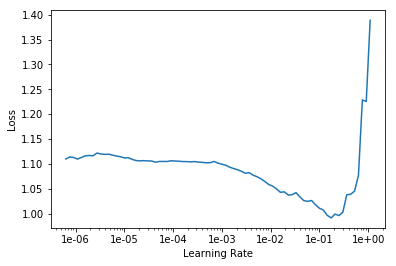

In [0]:
learn_cls_lstm.lr_find()
learn_cls_lstm.recorder.plot()

In [0]:
learn_cls_lstm.fit_one_cycle(5,1e-2)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.693145,0.529656,0.795628,0.204372,00:05
1,0.674349,0.507371,0.808466,0.191534,00:05
2,0.676386,0.501782,0.807078,0.192922,00:05
3,0.653523,0.481055,0.817835,0.182165,00:05
4,0.664892,0.477099,0.818876,0.181124,00:05


In [0]:
train_preds=learn_cls_lstm.get_preds(ds_type=DatasetType.Train)
print('Training set accuracy')
accuracy(train_preds[0],train_preds[1]).item()

Training set accuracy


tensor(0.8123)

We will trains some more, as training error does not suggest overfitting.

As suggeted by fast.ai, we should do gradual unfreezing, to avoid catastrophic forgetting, and continue training the model by unfreezing lower layers.

In [0]:
learn_cls_lstm.freeze_to(-2)
learn_cls_lstm.fit_one_cycle(5,1e-3,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.652236,0.474767,0.815753,0.184247,00:06
1,0.635457,0.471870,0.820264,0.179736,00:06
2,0.627305,0.454707,0.816100,0.183900,00:06
3,0.603991,0.448908,0.829285,0.170715,00:06
4,0.582497,0.449186,0.829979,0.170021,00:06


In [0]:
train_preds=learn_cls_lstm.get_preds(ds_type=DatasetType.Train)
print('Training set accuracy')
accuracy(train_preds[0],train_preds[1]).item()

Training set accuracy


0.8327257037162781

Unfreezing the whole model and training a bit more, as training error does not suggest overfitting.

In [0]:
learn_cls_lstm.unfreeze()
learn_cls_lstm.fit_one_cycle(5,1e-3,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.568088,0.421988,0.834837,0.165163,00:12
1,0.539325,0.416151,0.833796,0.166204,00:12
2,0.472961,0.394166,0.848022,0.151978,00:12
3,0.405060,0.390256,0.851839,0.148161,00:13
4,0.359585,0.391342,0.854962,0.145038,00:13


In [0]:
train_preds=learn_cls_lstm.get_preds(ds_type=DatasetType.Train)
print('Training set accuracy')
accuracy(train_preds[0],train_preds[1]).item()

Training set accuracy


0.9198784828186035

We achived an accuracy of **~85%** percent on the validation set. Probably we overtiffed a bit on the training set, since the variance became higher (6%).

In [0]:
learn_cls_lstm.save('cls_lstm')

# Conclusion

Comparing our final result to the first approach and other works found, we can see that we managed to raise the accuracy from 79% to around 85%.

Let's check the F1 score of the final model:

In [0]:
valid_preds=learn_cls_lstm.get_preds(ds_type=DatasetType.Valid)
one_hots = transform_to_one_hot_enc(valid_preds[1])
f1score = fbeta(valid_preds[0], one_hots, thresh=0.5, beta=1, sigmoid=False)
print('F1 score {}'.format(f1score.item()))

F1 score 0.8448993563652039


Let's do some error analysis and look at the missclassification errors in more details.

In [0]:
interp = TextClassificationInterpretation.from_learner(learn_cls_lstm) 

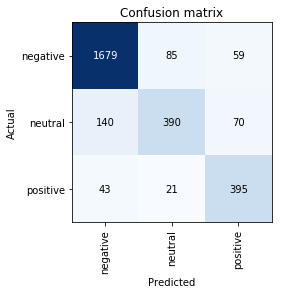

In [0]:
interp.plot_confusion_matrix()

We can see that most of the missclasification happened for 
* neutral posts, which were predicted to be negative (140)
* negative posts, which were predicted to be neutral (85)
* neutral posts, which were predicted to be poisitibe (70)

This suggest, that it is hard for the model to learn to classify the neutral tweet correctly, and also hard to differentiate between neutral and negative tweets.

Let's check the tweets, which had the top 10 losses.

In [0]:
interp.show_top_losses(10,100)

Text,Prediction,Actual,Loss,Probability
xxbos is it possible to xxunk to p a segment where i have a xxunk xxunk ?,positive,neutral,8.55,0.00
xxbos thanks i just sent a dm with this info .,positive,neutral,8.35,0.00
"xxbos not a happy customer . we 've waited xxunk , not to mention $ 150 and six months of xxunk training , we need 2 be there tmrw .",positive,negative,8.29,0.01
"xxbos xxunk hi , when do direct flights from houston to xxunk begin ? do n't see any days in march ?",positive,neutral,6.56,0.00
xxbos i should also add the weather conditions are terrible . expecting 18 inches of snow . any advice ?,positive,neutral,6.40,0.00
"xxbos no , i have n't done that yet . is that something i can do online ? thx !",positive,negative,6.35,0.02
xxbos and they cancelled flighted my flight and left me with no help to find a hotel to stay in . i slept in an airport for a xxunk,positive,negative,5.80,0.00
xxbos xxunk was cancelled flightled not delayed . re - flight booking problems still 90 miles from home . at least acknowledge the cancelled flightlation .,positive,negative,5.55,0.01
xxbos i have a flight on sunday the xxunk to columbus from denver . i just got a travel alert on my southwest app . is the rescheduling,positive,neutral,5.44,0.00
xxbos stranded in north xxunk and trying to figure out options but ca n't get anyone to talk to,negative,negative,5.02,0.98


We can see that some of these are really hard to classify, there is just not enough context most of the time.

Using the pre-trained Language Model in a straighforward way to predict the sentiment of the tweets just does not give great results (only around 85% accuracy). Probably smarter feature engineering and hyperparamter tuning is required for better results.

This might be because Twitter text data is very different from Wikipedia text data, making it harder for the model to generalize. Also, the tweets were annotated manually, by humans and some of them can be quite ambiguous (could be classified as neutral/or slightly positive/slightly negative based on interpretation).

One possible way to improve the model accuracy would be to fine-tune using a larger dataset of Twitter customer support data (e.g.: [Customer Support on Twitter](https://www.kaggle.com/thoughtvector/customer-support-on-twitter))
